<font size="+4">Exploration of gene expression data</font>

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import altair as alt
import plotly.express as px
import umap
import matplotlib.pyplot as plt
import seaborn as sns

/Users/jnatali/miniforge3/envs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [4]:
gexp = pl.read_csv("data.csv.zst")
labels = pl.read_csv("labels.csv.zst")
gexp = gexp.join(labels, left_on="sample", right_on="sample")
print(len(gexp))
print(len(labels))

801
801


In [5]:
print(gexp.head())

shape: (5, 20_533)
┌──────────┬────────┬──────────┬──────────┬───┬────────────┬────────────┬────────────┬───────┐
│ sample   ┆ gene_0 ┆ gene_1   ┆ gene_2   ┆ … ┆ gene_20528 ┆ gene_20529 ┆ gene_20530 ┆ Class │
│ ---      ┆ ---    ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---   │
│ str      ┆ f64    ┆ f64      ┆ f64      ┆   ┆ f64        ┆ f64        ┆ f64        ┆ str   │
╞══════════╪════════╪══════════╪══════════╪═══╪════════════╪════════════╪════════════╪═══════╡
│ sample_0 ┆ 0.0    ┆ 2.017209 ┆ 3.265527 ┆ … ┆ 8.921326   ┆ 5.286759   ┆ 0.0        ┆ PRAD  │
│ sample_1 ┆ 0.0    ┆ 0.592732 ┆ 1.588421 ┆ … ┆ 9.397854   ┆ 2.094168   ┆ 0.0        ┆ LUAD  │
│ sample_2 ┆ 0.0    ┆ 3.511759 ┆ 4.327199 ┆ … ┆ 10.09047   ┆ 1.683023   ┆ 0.0        ┆ PRAD  │
│ sample_3 ┆ 0.0    ┆ 3.663618 ┆ 4.507649 ┆ … ┆ 9.684365   ┆ 3.292001   ┆ 0.0        ┆ PRAD  │
│ sample_4 ┆ 0.0    ┆ 2.655741 ┆ 2.821547 ┆ … ┆ 9.461191   ┆ 5.110372   ┆ 0.0        ┆ BRCA  │
└──────────┴────────┴──────────

In [19]:
#gexp_t = gexp.drop(["sample", "Class"]).transpose(column_names=gexp["sample"].to_list())
gexp_t = gexp.drop(["sample", "Class"]).transpose()
gexp_t.columns = gexp["sample"]
gexp_t.describe()

statistic,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,…,sample_764,sample_765,sample_766,sample_767,sample_768,sample_769,sample_770,sample_771,sample_772,sample_773,sample_774,sample_775,sample_776,sample_777,sample_778,sample_779,sample_780,sample_781,sample_782,sample_783,sample_784,sample_785,sample_786,sample_787,sample_788,sample_789,sample_790,sample_791,sample_792,sample_793,sample_794,sample_795,sample_796,sample_797,sample_798,sample_799,sample_800
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,…,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0,20531.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",6.514196,6.276564,5.95563,6.295755,6.42398,6.553991,6.486754,6.558027,6.442644,6.307461,6.521175,6.533937,6.647362,6.194886,6.209201,6.460375,6.559923,6.551385,6.491945,6.447928,6.180463,6.303874,6.503754,6.069148,6.265975,6.699507,6.258423,6.276466,6.532713,6.490515,6.301424,6.131186,6.412577,6.506228,6.508074,6.188419,…,6.306951,6.415647,6.353664,6.427747,6.48334,6.51116,6.472739,6.206152,6.508127,6.704242,6.35577,6.46574,6.546993,6.354087,6.498613,6.43941,6.293308,6.39319,6.556011,6.049789,6.302356,6.184188,6.51513,6.29581,6.352476,6.611881,6.334764,6.361936,6.153851,6.245023,6.436225,6.570715,6.284252,6.459381,7.074519,6.562049,6.558847
"""std""",4.021607,4.148286,4.234517,4.10817,4.084076,4.014411,4.053986,4.029386,4.063046,4.088474,4.014555,4.028149,3.924009,4.191621,4.151224,4.049078,4.006046,4.001648,4.063737,4.044292,4.177814,4.158957,4.013101,4.250538,4.164872,3.943746,4.125268,4.153949,4.038776,4.021935,4.112068,4.137737,4.110976,4.041581,4.017807,4.142723,…,4.166388,4.108806,4.075978,4.053292,4.039803,4.032035,4.041664,4.167031,4.022365,3.927822,4.102516,4.039818,4.010879,4.104025,4.023924,4.056303,4.120097,4.103411,4.011508,4.212974,4.128199,4.153319,4.048607,4.129407,4.047184,4.023056,4.126731,4.091815,4.192973,4.153213,4.062201,3.978395,4.11461,4.03603,3.690176,3.978697,3.978511
"""min""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",2.94572,2.006585,1.306846,2.175652,2.522181,2.976345,2.764643,2.897105,2.51162,2.296311,2.892605,2.773131,3.324753,1.967943,1.950207,2.670546,2.996642,2.937778,2.61584,2.740323,1.822689,2.164883,2.81791,1.543842,1.851119,3.32151,2.221939,2.017886,2.773427,2.738314,2.187926,2.085289,2.397064,2.869042,2.815719,1.940843,…,2.196701,2.338852,2.358874,2.588301,2.69274,2.778356,2.667597,1

In [16]:
#corrs = gexp.select(pl.exclude(("sample", "Class"))).corr()
corrs = gexp_t.corr()
corrs.head()

sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,sample_10,sample_11,sample_12,sample_13,sample_14,sample_15,sample_16,sample_17,sample_18,sample_19,sample_20,sample_21,sample_22,sample_23,sample_24,sample_25,sample_26,sample_27,sample_28,sample_29,sample_30,sample_31,sample_32,sample_33,sample_34,sample_35,sample_36,…,sample_764,sample_765,sample_766,sample_767,sample_768,sample_769,sample_770,sample_771,sample_772,sample_773,sample_774,sample_775,sample_776,sample_777,sample_778,sample_779,sample_780,sample_781,sample_782,sample_783,sample_784,sample_785,sample_786,sample_787,sample_788,sample_789,sample_790,sample_791,sample_792,sample_793,sample_794,sample_795,sample_796,sample_797,sample_798,sample_799,sample_800
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.0,0.858674,0.882858,0.933547,0.898388,0.939973,0.893296,0.928104,0.856759,0.920396,0.91034,0.844255,0.943852,0.899006,0.885728,0.892823,0.867267,0.864769,0.860961,0.943034,0.846935,0.84716,0.864574,0.880323,0.823874,0.876332,0.877397,0.885587,0.875279,0.840198,0.883229,0.862035,0.855294,0.919345,0.956811,0.888258,0.869313,…,0.85926,0.848476,0.868548,0.881754,0.886745,0.893503,0.898347,0.877851,0.892186,0.883243,0.844285,0.896017,0.873585,0.851943,0.871481,0.880762,0.870348,0.846139,0.882501,0.950233,0.863413,0.888044,0.858241,0.874655,0.922438,0.837287,0.881634,0.870421,0.868965,0.890581,0.933247,0.867421,0.895631,0.880156,0.867416,0.950518,0.936407
0.858674,1.0,0.876127,0.879254,0.897233,0.874776,0.864916,0.862941,0.902603,0.843972,0.898507,0.881391,0.895291,0.878866,0.887533,0.899748,0.935458,0.876644,0.887994,0.892065,0.890961,0.899741,0.918607,0.876456,0.866303,0.918988,0.896232,0.894171,0.910571,0.844736,0.911521,0.891062,0.902685,0.895717,0.884138,0.903874,0.863083,…,0.873423,0.880181,0.904613,0.906868,0.900928,0.895003,0.909691,0.923021,0.899962,0.921892,0.884557,0.918828,0.947804,0.854359,0.914207,0.936962,0.933108,0.872294,0.908791,0.857287,0.917898,0.89103,0.887082,0.893598,0.877972,0.836814,0.910704,0.901841,0.889107,0.898274,0.880361,0.921824,0.891132,0.898575,0.868728,0.880527,0.908454
0.882858,0.876127,1.0,0.926245,0.887323,0.902466,0.834842,0.86061,0.868537,0.900414,0.883662,0.837406,0.898149,0.872891,0.892354,0.874615,0.865976,0.84826,0.835708,0.914219,0.870057,0.854065,0.863559,0.878052,0.839438,0.850601,0.878722,0.882285,0.875326,0.850217,0.898393,0.878745,0.845827,0.862567,0.908618,0.89987,0.841773,…,0.839321,0.838771,0.875039,0.87513,0.878149,0.861559,0.893463,0.877242,0.866706,0.871483,0.843164,0.875931,0.854862,0.836913,0.877493,0.873369,0.868075,0.835532,0.869277,0.917402,0.880075,0.88275,0.841724,0.88839,0.922706,0.819455,0.894365,0.878098,0.894225,0.890274,0.911696,0.859781,0.885068,0.87356,0.830874,0.915971,0.911442
0.933547,0.879254,0.926245,1.0,0.915742,0.935346,0.862733,0.90763,0.886185,0.931775,0.912062,0.845464,0.94293,0.879694,0.902375,0.905932,0.880572,0.86388,0.858813,0.960819,0.885357,0.860093,0.878597,0.885078,0.843899,0.88061,0.890075,0.901103,0.883884,0.860146,0.903946,0.899764,0.858577,0.889,0.950827,0.917721,0.866517,…,0.851515,0.85076,0.884088,0.890348,0.907351,0.896181,0.920364,0.887923,0.901255,0.891936,0.851478,0.898804,0.874644,0.840796,0.885776,0.895889,0.875613,0.853039,0.891421,0.938229,0.885634,0.895328,0.857487,0.909137,0.954331,0.844101,0.906243,0.898827,0.901514,0.906321,0.956119,0.884342,0.90724,0.886809,0.855107,0.950281,0.952191
0.898388,0.897233,0.887323,0.915742,1.0,0.909522,0.893631,0.89482,0.926642,0.896679,0.95514,0.863561,0.912098,0.910077,0.942461,0.964012,0.899838,0.886556,0.881568,0.923325,0.935537,0.881866,0.892904,0.931491,0.857889,0.896253,0.897044,0.932418,0.919026,0.888766,0.941247,0.951522,0.883429,0.92496,0.9

In [21]:
corrs.shape

(801, 801)

# UMAP dimensionality reduction

/Users/jnatali/miniforge3/envs/main/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


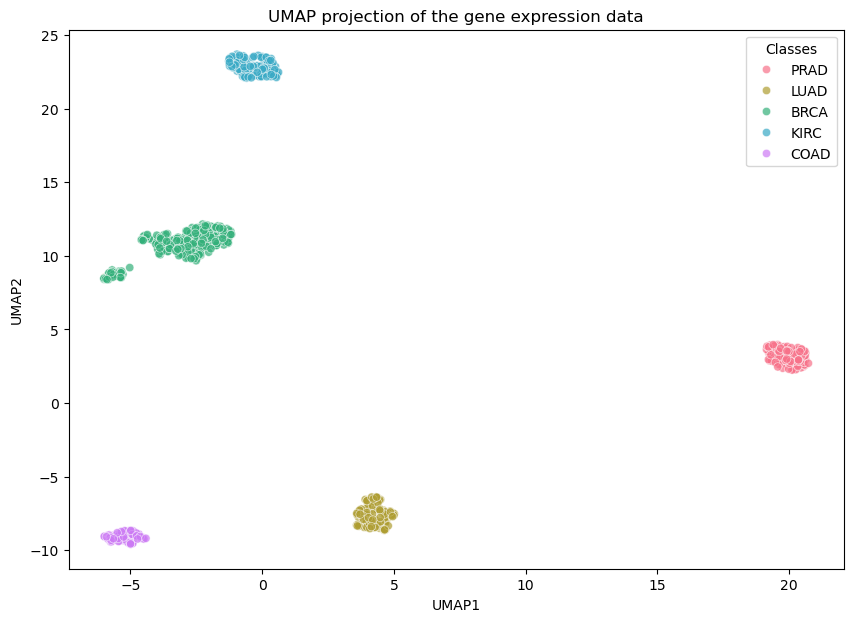

In [61]:
# Perform UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(gexp.drop(["sample", "Class"]))

gexp_umap = pl.DataFrame(embedding, schema=["component1", "component2"]).with_columns(
    sample = gexp["sample"],
    Class = gexp["Class"],
)

# Plotting the results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=gexp_umap, x="component1", y="component2", hue="Class", palette="husl", alpha=0.7)

plt.title("UMAP projection of the gene expression data")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Classes")
plt.show()


Very impressive! UMAP with default settings is able to completely separate the classes with only two dimensions. 

In [40]:
gexp_umap

UMAP1,UMAP2,sample,Class
f32,f32,str,str
17.226868,6.321063,"""sample_0""","""PRAD"""
-11.784132,-0.567649,"""sample_1""","""LUAD"""
18.329853,5.681085,"""sample_2""","""PRAD"""
18.284256,5.644632,"""sample_3""","""PRAD"""
-2.684746,9.60227,"""sample_4""","""BRCA"""
…,…,…,…
-2.698186,9.961187,"""sample_796""","""BRCA"""
-10.036757,-1.695487,"""sample_797""","""LUAD"""
3.641929,-8.275664,"""sample_798""","""COAD"""


# tSNE dimensionality reduction

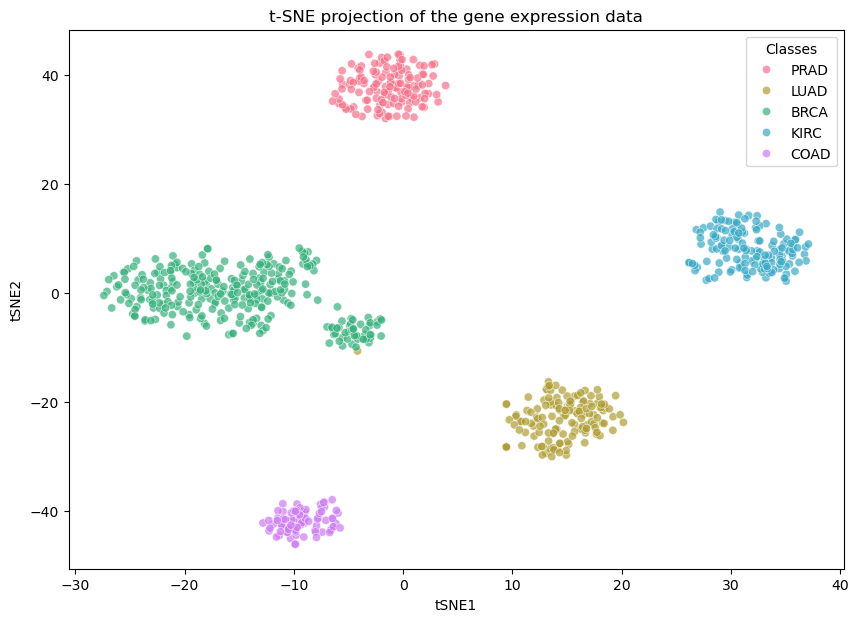

In [62]:
# Perform tSNE dimensionality reduction
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedding = tsne.fit_transform(gexp.drop(["sample", "Class"]))

gexp_tsne = pl.DataFrame(embedding, schema=["component1", "component2"]).with_columns(
    sample = gexp["sample"],
    Class = gexp["Class"],
)

# Plotting the results
plt.figure(figsize=(10, 7))
sns.scatterplot(data=gexp_tsne, x="component1", y="component2", hue="Class", palette="husl", alpha=0.7)

plt.title("t-SNE projection of the gene expression data")
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.legend(title="Classes")
plt.show()


In [64]:
alt.Chart(
    pl.concat(
        (
            gexp_umap.with_columns(method=pl.lit("UMAP")),
            gexp_tsne.with_columns(method=pl.lit("tSNE")),
        )
    )
).mark_point(
).encode(
    alt.X("component1"), 
    alt.Y("component2"),
    alt.Color("Class"),
    alt.Column("method")
)

alt.Chart(...)

## Comparison of UMAP and tSNE

To quantify the quality of the UMAP and t-SNE methods in their ability to separate classes in the dataset, we can use several statistical methods to measure clustering performance. Two common metrics are:

1. Silhouette Score: Measures how similar each point is to its own cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where a higher score indicates that the samples are well clustered with other samples that are similar to them and far from other clusters.

1. Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, it evaluates the ratio of the sum of between-cluster dispersion to within-cluster dispersion for all clusters. Higher values indicate better-defined clusters.

In [65]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Calculate Silhouette Score for UMAP and t-SNE
silhouette_umap = silhouette_score(gexp_umap[["component1", "component2"]], gexp_umap["Class"])
silhouette_tsne = silhouette_score(gexp_tsne[["component1", "component2"]], gexp_tsne["Class"])

# Calculate Calinski-Harabasz Index for UMAP and t-SNE
calinski_umap = calinski_harabasz_score(gexp_umap[["component1", "component2"]], gexp_umap["Class"])
calinski_tsne = calinski_harabasz_score(gexp_tsne[["component1", "component2"]], gexp_tsne["Class"])

# Print the results
print(f'Silhouette Score for UMAP: {silhouette_umap:.4f}')
print(f'Silhouette Score for t-SNE: {silhouette_tsne:.4f}')
print(f'Calinski-Harabasz Index for UMAP: {calinski_umap:.4f}')
print(f'Calinski-Harabasz Index for t-SNE: {calinski_tsne:.4f}')

Silhouette Score for UMAP: 0.8937
Silhouette Score for t-SNE: 0.7998
Calinski-Harabasz Index for UMAP: 20491.4853
Calinski-Harabasz Index for t-SNE: 4986.1073


# Training a Linear Regression model to predict classes

In [72]:
# from sklearn.linear_model import Ridge
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

gene_expression_array = gexp.drop(["sample", "Class"]).to_numpy()
classes = gexp["Class"].to_list()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression_array, classes, test_size=0.2, random_state=12)

# Initialize the Ridge Classifier
ridge_clf = RidgeClassifier(alpha=1.0)  # Alpha is the regularization strength

# Fit the model to the training data
ridge_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge_clf.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        58
        COAD       1.00      1.00      1.00        12
        KIRC       1.00      1.00      1.00        21
        LUAD       1.00      1.00      1.00        40
        PRAD       1.00      1.00      1.00        30

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161

Confusion Matrix:
[[58  0  0  0  0]
 [ 0 12  0  0  0]
 [ 0  0 21  0  0]
 [ 0  0  0 40  0]
 [ 0  0  0  0 30]]


# Training a JAX model to predict classes

In [70]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from flax.training import train_state
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Prepare the data
gene_expression_array = gexp.drop(["sample", "Class"]).to_numpy()
classes = gexp["Class"].to_list()

# Encode class labels
label_encoder = LabelEncoder()
encoded_classes = label_encoder.fit_transform(classes)
num_classes = len(label_encoder.classes_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(gene_expression_array, encoded_classes, test_size=0.2, random_state=42)

# Define the neural network model using Flax with regularization
class NeuralNetwork(nn.Module):
    hidden_dim1: int = 16
    hidden_dim2: int = 8
    output_dim: int = num_classes
    dropout_rate: float = 0.5
    weight_decay: float = 1e-4

    @nn.compact
    def __call__(self, x, training: bool = True):
        x = nn.Dense(self.hidden_dim1, kernel_init=nn.initializers.lecun_normal())(x)
        x = nn.relu(x)
        x = nn.Dropout(self.dropout_rate, deterministic=not training)(x)  # Dropout layer for regularization
        x = nn.Dense(self.hidden_dim2, kernel_init=nn.initializers.lecun_normal())(x)
        x = nn.relu(x)
        x = nn.Dropout(self.dropout_rate, deterministic=not training)(x)  # Dropout layer for regularization
        x = nn.Dense(self.output_dim, kernel_init=nn.initializers.lecun_normal())(x)
        x = nn.softmax(x)  # Output probabilities for each class
        return x

# Initialize the model, state, and optimizer with weight decay (L2 regularization)
def create_train_state(rng, learning_rate, model, input_shape):
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adamw(learning_rate, weight_decay=model.weight_decay)  # Use adamw optimizer with weight decay
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Define the loss function and accuracy metric
def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=num_classes)
    loss = optax.softmax_cross_entropy(logits=logits, labels=one_hot_labels)
    return jnp.mean(loss)

def compute_metrics(logits, labels):
    loss = cross_entropy_loss(logits, labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return {'loss': loss, 'accuracy': accuracy}

# Training step with dropout regularization
@jax.jit
def train_step(state, batch, rng):
    def loss_fn(params):
        # Generate new PRNG key for each training step
        new_rng, dropout_rng = jax.random.split(rng)
        logits = state.apply_fn({'params': params}, batch['X'], training=True, rngs={'dropout': dropout_rng})
        loss = cross_entropy_loss(logits, batch['y'])
        return loss

    grads = jax.grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state

# Evaluation step
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['X'], training=False)
    return compute_metrics(logits, batch['y'])

# Train the model
def train_model(num_epochs, train_state, X_train, y_train, X_test, y_test):
    rng = jax.random.PRNGKey(0)  # RNG key for dropout
    for epoch in range(num_epochs):
        state = train_state
        # Generate a new PRNG key for each epoch
        rng, input_rng = jax.random.split(rng)
        # Training step
        train_state = train_step(state, {'X': X_train, 'y': y_train}, input_rng)

        # Evaluate the model
        metrics = eval_step(train_state, {'X': X_test, 'y': y_test})

        print(f"Epoch {epoch+1}, Loss: {metrics['loss']:.4f}, Accuracy: {metrics['accuracy']:.4f}")

    return train_state

# Set up model, optimizer, and training state
rng = jax.random.PRNGKey(0)
model = NeuralNetwork()
state = create_train_state(rng, learning_rate=0.01, model=model, input_shape=(X_train.shape[1],))

# Train the model
trained_state = train_model(100, state, X_train, y_train, X_test, y_test)

Epoch 1, Loss: 1.5260, Accuracy: 0.3789
Epoch 2, Loss: 1.5260, Accuracy: 0.3789
Epoch 3, Loss: 1.5260, Accuracy: 0.3789
Epoch 4, Loss: 1.5260, Accuracy: 0.3789
Epoch 5, Loss: 1.5260, Accuracy: 0.3789
Epoch 6, Loss: 1.5260, Accuracy: 0.3789
Epoch 7, Loss: 1.5260, Accuracy: 0.3789
Epoch 8, Loss: 1.5260, Accuracy: 0.3789
Epoch 9, Loss: 1.5260, Accuracy: 0.3789
Epoch 10, Loss: 1.5260, Accuracy: 0.3789
Epoch 11, Loss: 1.5260, Accuracy: 0.3789
Epoch 12, Loss: 1.5260, Accuracy: 0.3789
Epoch 13, Loss: 1.5260, Accuracy: 0.3789
Epoch 14, Loss: 1.5260, Accuracy: 0.3789
Epoch 15, Loss: 1.5260, Accuracy: 0.3789
Epoch 16, Loss: 1.5260, Accuracy: 0.3789
Epoch 17, Loss: 1.5260, Accuracy: 0.3789
Epoch 18, Loss: 1.5260, Accuracy: 0.3789
Epoch 19, Loss: 1.5260, Accuracy: 0.3789
Epoch 20, Loss: 1.5260, Accuracy: 0.3789
Epoch 21, Loss: 1.5260, Accuracy: 0.3789
Epoch 22, Loss: 1.5260, Accuracy: 0.3789
Epoch 23, Loss: 1.5260, Accuracy: 0.3789
Epoch 24, Loss: 1.5260, Accuracy: 0.3789
Epoch 25, Loss: 1.5260, A

Test Accuracy: 0.3789

Classification Report:
              precision    recall  f1-score   support

        BRCA       0.38      1.00      0.55        61
        COAD       0.00      0.00      0.00        17
        KIRC       0.00      0.00      0.00        25
        LUAD       0.00      0.00      0.00        29
        PRAD       0.00      0.00      0.00        29

    accuracy                           0.38       161
   macro avg       0.08      0.20      0.11       161
weighted avg       0.14      0.38      0.21       161



/Users/jnatali/miniforge3/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jnatali/miniforge3/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jnatali/miniforge3/envs/main/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

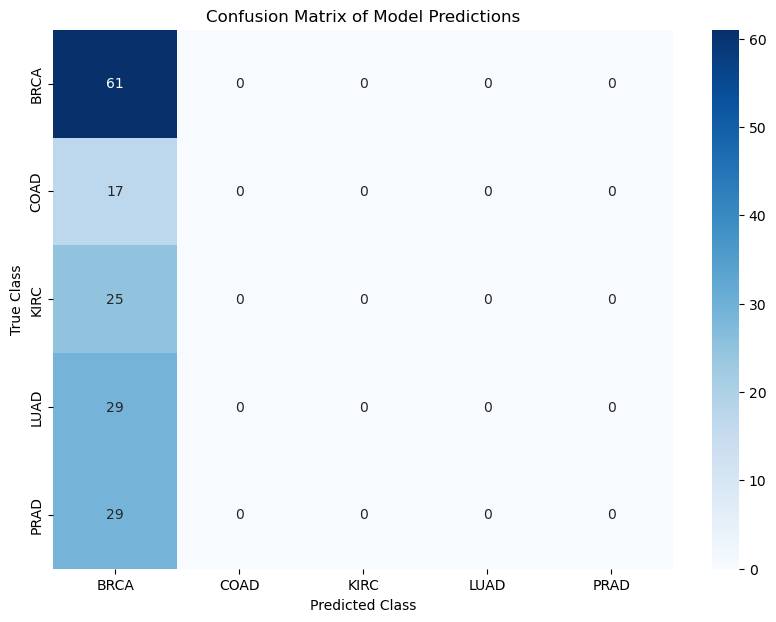

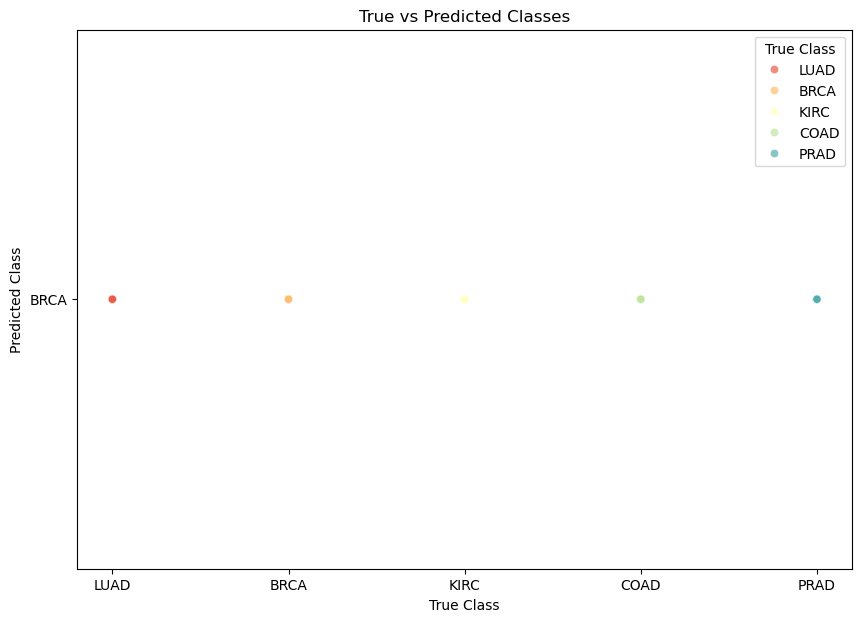

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'trained_state' is the trained model from previous steps

# Function to predict using the trained model with dropout set to deterministic (no dropout)
def predict(state, X, rng):
    logits = state.apply_fn({'params': state.params}, X, training=False, rngs={'dropout': rng})
    return jnp.argmax(logits, axis=-1)

# Generate a new PRNG key for predictions
rng = jax.random.PRNGKey(0)

# Predict the classes on the test set
y_pred = predict(trained_state, X_test, rng)

# Convert JAX arrays to NumPy for compatibility with sklearn
y_pred_np = np.array(y_pred)
y_test_np = np.array(y_test)

# Evaluate model performance
accuracy = np.mean(y_pred_np == y_test_np)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_np, target_names=label_encoder.classes_))

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

# Plotting the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix of Model Predictions')
plt.show()

# Create a DataFrame for plotting predictions
plot_df = pd.DataFrame({'True Class': label_encoder.inverse_transform(y_test_np), 
                        'Predicted Class': label_encoder.inverse_transform(y_pred_np)})

# Plotting the true vs. predicted classes
plt.figure(figsize=(10, 7))
sns.scatterplot(data=plot_df, x='True Class', y='Predicted Class', hue='True Class', palette='Spectral', alpha=0.7)
plt.title('True vs Predicted Classes')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show()